In [1]:
import os
import numpy as np
from tabulate import tabulate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import ImageFolder

from models.HidingUNet import UnetGenerator
from models.RevealNet import RevealNet

import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=128
BATCH_SIZE=50
WORKERS=8
DATA_DIR = './ImageNet' 
CHECKPOINT_DIR = './checkpoint.pth.tar'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
def torch2img(tensor):
    img = tensor.permute(0, 2, 3, 1).clamp(0.0, 1.0)
    img = img.detach().cpu().numpy()
    img = (img*255).astype(np.uint8)
    return img

In [4]:
# Data Path
valdir = os.path.join(DATA_DIR, 'val')

# Transforms for data
transforms_secret = transforms.Compose([
            transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),  
            transforms.ToTensor(),
        ])  
transforms_cover = transforms.Compose([
            transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),  
            transforms.ToTensor(),
        ])  

# Datasets for covers and secrets
test_dataset_secret = ImageFolder(valdir, transforms_secret)
test_dataset_cover = ImageFolder(valdir, transforms_cover)

# Respective dataloaders
test_loader_secret = DataLoader(test_dataset_secret, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=WORKERS)
test_loader_cover = DataLoader(test_dataset_cover, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=WORKERS)
test_loader = zip(test_loader_secret, test_loader_cover)

In [5]:
# Hiding and Revealing Models
Hnet = UnetGenerator(input_nc=3, output_nc=3, num_downs=5, norm_layer=nn.BatchNorm2d, output_function=nn.Tanh)
Rnet = RevealNet(input_nc=3, output_nc=3, nhf=64, norm_layer=nn.BatchNorm2d, output_function=nn.Sigmoid)

Hnet = torch.nn.DataParallel(Hnet).cuda()
Rnet = torch.nn.DataParallel(Rnet).cuda()

# Loading pretrained weights
checkpoint = torch.load(CHECKPOINT_DIR)
Hnet.load_state_dict(checkpoint['H_state_dict'])
Rnet.load_state_dict(checkpoint['R_state_dict'])

<Figure size 432x288 with 0 Axes>

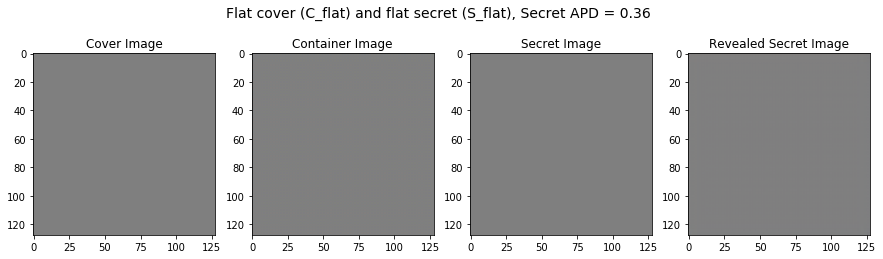

<Figure size 432x288 with 0 Axes>

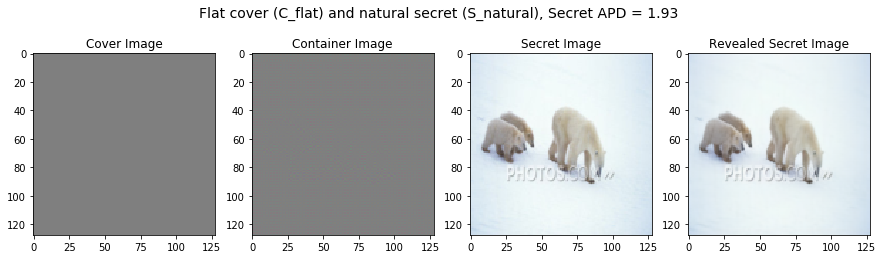

<Figure size 432x288 with 0 Axes>

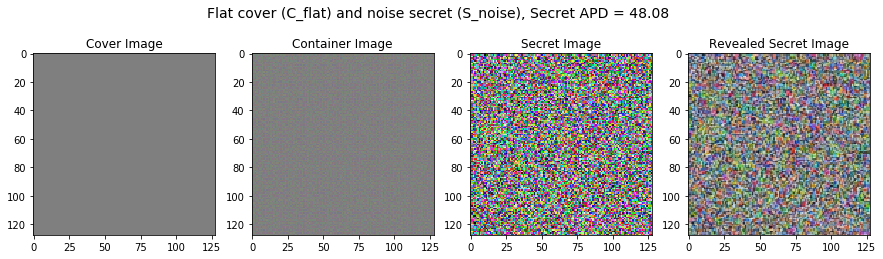

<Figure size 432x288 with 0 Axes>

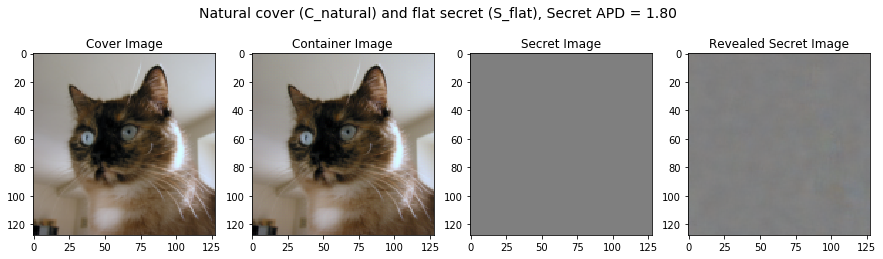

<Figure size 432x288 with 0 Axes>

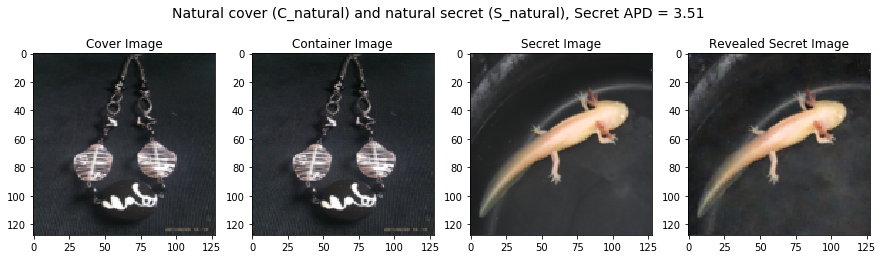

<Figure size 432x288 with 0 Axes>

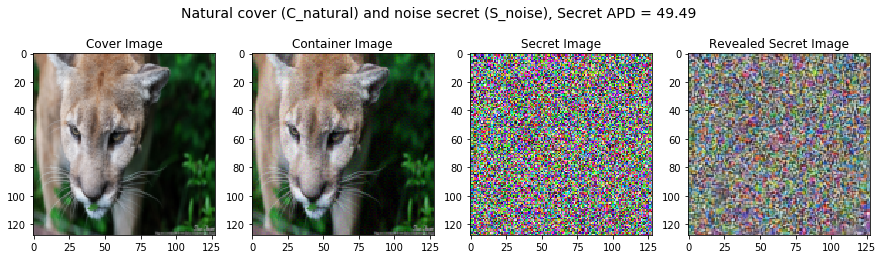

<Figure size 432x288 with 0 Axes>

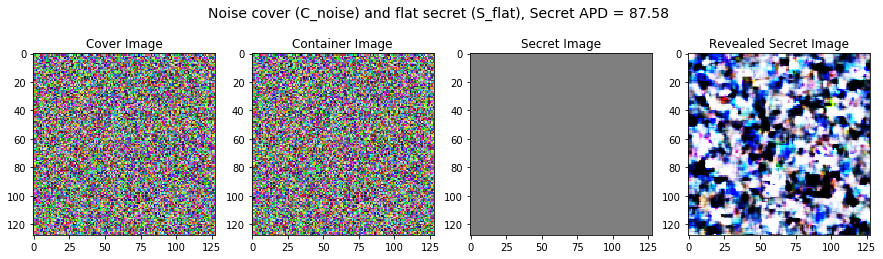

<Figure size 432x288 with 0 Axes>

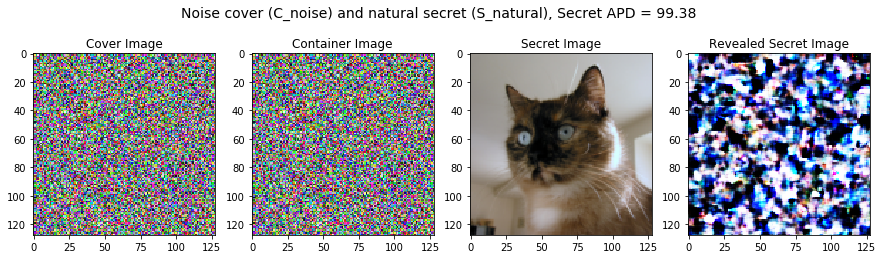

<Figure size 432x288 with 0 Axes>

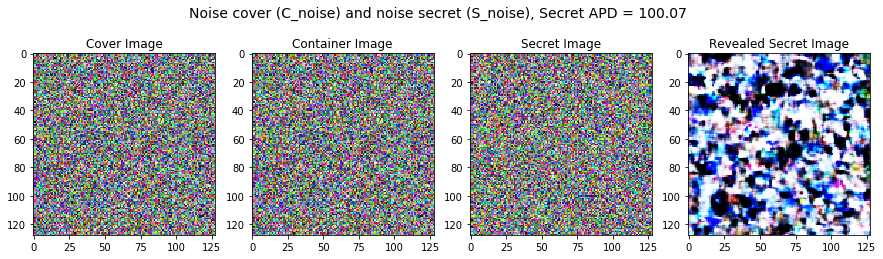

In [6]:
Hnet.eval()
Rnet.eval()

# List of secret APDs
diffR_list = np.zeros(9)

with torch.no_grad():
    test_data_iter = iter(test_loader)
    (secret_img_, secret_target_), (cover_img_, cover_target_) = next(test_data_iter)
    for i in range(9):
        (secret_img, secret_target), (cover_img, cover_target) = (secret_img_.clone(), secret_target_.clone()), (cover_img_.clone(), cover_target_.clone())
        
        size = secret_img.size()
        secret_img = secret_img.cuda()
        cover_img = cover_img.cuda()

        if i == 0:
            # Flat cover and flat secret
            secret_img = secret_img.new_full(size, 0.5)
            cover_img = cover_img.new_full(size, 0.5)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Flat cover (C_flat) and flat secret (S_flat), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[0])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[0])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[0])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[0])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

        elif i == 1:
            # Flat cover and natural secret
            cover_img = cover_img.new_full(size, 0.5)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Flat cover (C_flat) and natural secret (S_natural), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[1])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[1])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[1])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[1])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()
            
        elif i == 2:
            # Flat cover and noise secret
            secret_img = torch.rand_like(secret_img)
            cover_img = cover_img.new_full(size, 0.5)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Flat cover (C_flat) and noise secret (S_noise), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[2])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[2])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[2])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[2])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()
            
        elif i == 3:
            # Natural cover and flat secret
            secret_img = secret_img.new_full(size, 0.5)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Natural cover (C_natural) and flat secret (S_flat), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[3])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[3])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[3])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[3])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

        elif i == 4:
            # Natural cover and natural secret

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Natural cover (C_natural) and natural secret (S_natural), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[4])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[4])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[4])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[4])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

        elif i == 5:
            # Natural cover and noise secret
            secret_img = torch.rand_like(secret_img)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Natural cover (C_natural) and noise secret (S_noise), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[5])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[5])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[5])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[5])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()
            
        elif i == 6:
            # Noise cover and flat secret
            secret_img = secret_img.new_full(size, 0.5)
            cover_img = torch.rand_like(cover_img)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Noise cover (C_noise) and flat secret (S_flat), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[6])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[6])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[6])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[6])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

        elif i == 7:
            # Noise cover and natural secret
            cover_img = torch.rand_like(cover_img)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Noise cover (C_noise) and natural secret (S_natural), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[7])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[7])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[7])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[7])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

        elif i == 8:
            # Noise cover and noise secret
            secret_img = torch.rand_like(secret_img)
            cover_img = torch.rand_like(cover_img)

            # Hiding and Revealing
            se = Hnet(secret_img)
            container_img = cover_img + se
            rev_secret_img = Rnet(container_img)

            # Calculate the secret APD
            diffR = (rev_secret_img - secret_img).abs().mean()*255
            diffR_list[i] = round(diffR.item(), 2)

            # Visualize an example of cover, container, secret, and revealed secret images
            fig = plt.figure()
            f, axarr = plt.subplots(1,4, figsize=(15,4))
            f.suptitle("Noise cover (C_noise) and noise secret (S_noise), Secret APD = %.2f" % (diffR.item()), fontsize=14)

            axarr[0].imshow(torch2img(cover_img)[8])
            axarr[0].title.set_text('Cover Image')

            axarr[1].imshow(torch2img(container_img)[8])
            axarr[1].title.set_text('Container Image')

            axarr[2].imshow(torch2img(secret_img)[8])
            axarr[2].title.set_text('Secret Image')
            
            axarr[3].imshow(torch2img(rev_secret_img)[8])
            axarr[3].title.set_text('Revealed Secret Image')
            
            plt.show()

In [7]:
# Print the final table of secret APDs (Table 3)
print()
print("Table 3: Secret APD performance with three types of images.\n         The rows and columns indicate cover images and secret images, respectively.")
print()
print(tabulate([['C_flat', diffR_list[0], diffR_list[1], diffR_list[2]], 
                ['C_natural', diffR_list[3], diffR_list[4], diffR_list[5]],
                ['C_noise', diffR_list[6], diffR_list[7], diffR_list[8]]], 
               headers=[" ", "S_flat", "S_natural", "S_noise"]))


Table 3: Secret APD performance with three types of images.
         The rows and columns indicate cover images and secret images, respectively.

             S_flat    S_natural    S_noise
---------  --------  -----------  ---------
C_flat         0.36         1.93      48.08
C_natural      1.8          3.51      49.49
C_noise       87.58        99.38     100.07
